### 1DCNN Module

In [15]:
import torch
import torch.nn as nn

In [31]:
class ODCM(nn.Module):
    def __init__(self, input_channels = 19, kernel_size = 10, dtype=torch.float32):
        super(ODCM, self).__init__()
        self.input_channels = input_channels
        self.kernel_size = kernel_size  # 1 X 10
        self.ncf = 120  # The number of the depth-wise convolutional filter used in the three layers is set to 120
        self.dtype = dtype
        self.cvf1 = nn.Conv1d(in_channels=self.input_channels, out_channels=self.input_channels, kernel_size=self.kernel_size, padding='valid', stride=1, groups=self.input_channels, dtype=self.dtype)
        self.cvf2 = nn.Conv1d(in_channels=self.cvf1.out_channels, out_channels=self.cvf1.out_channels, kernel_size=self.kernel_size, padding='valid', stride=1, groups=self.cvf1.out_channels, dtype=self.dtype)
        # For each channel (19 channels), has 120 independent features due to the depthwise convolution in third layer
        # 채널 한 개당 120개의 filter 를 할당해서 feature 를 뽑아낸다
        self.cvf3 = nn.Conv1d(in_channels=self.cvf2.out_channels, out_channels=self.ncf * self.cvf2.out_channels, kernel_size=self.kernel_size, padding='valid', stride=1, groups=self.cvf2.out_channels, dtype=self.dtype)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.cvf1(x)
        x = self.relu(x)
        x = self.cvf2(x)
        x = self.relu(x)
        x = self.cvf3(x)
        x = self.relu(x)
        # x = torch.reshape(x, ((int)(x.shape[0] / self.ncf), self.ncf, (int)(x.shape[1])))
        # Dimension: (Batch, 2280, L3) → (Batch, 120, 19, L3) → (Batch, 19, 120, L3)
        # x = x.view(x.shape[0], self.ncf, self.input_channels, -1)  # (Batch, 120, 19, L3)
        # x = x.permute(0, 2, 1, 3)  # (Batch, 19, 120, L3)
        
        return x

In [17]:
import mne
import torch

file_path = '/Users/hwangjeongho/Desktop/EEG Transformer/model-data/train/sub-001_eeg_chunk_1.set'

raw = mne.io.read_raw_eeglab(file_path, preload=True)
data = raw.get_data()  # shape: (19, 1425)

eeg_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)  # shape: (1, 19, 1425)


In [18]:
eeg_tensor.shape

torch.Size([1, 19, 1425])

In [10]:
model = ODCM(input_channels=19, kernel_size=10)
output = model(eeg_tensor)

print("Output shape:", output.shape)  # Expected: (1, 19, 120, Le)

Output shape: torch.Size([1, 19, 120, 1398])


### Truncated Normal Distribution Function
- For Positional Embedding (Initialization)
- To initialize the Weight or Embedding Vector
- To avoid too big weights or too small weights
- To avoid exploding gradient / vanishing gradient

- 모델 안의 weight나 embedding vector를 초기화하는 함수
- 훈련 시작 전에 좋은 초기값을 주기 위해 사용함.
- 평균이 0이고 표준편차가 1인 정규분포에서 특정 범위 (-2, +2) Sigma 사이에서만 값이 나오게 하고 싶다
- PyTorch 에서는 Truncated Normal 이 없기 때문에 돌아서 작업해야한다.
- 정규분포를 직접 뽑기 어려우니, 먼저 Uniform 분포 (0~1)에서 뽑은 다음, 그걸 정규분포의 형태로 바꿔서 쓰자


Step 1] 원하는 정규분포 범위 [a, b] → 확률 구간 [l, u]

Step 2] [l, u] → [-1, 1] 매핑 → uniform 값 생성

Step 3] uniform → 정규분포로 변환 (inverse CDF = erfinv)

Step 4] 평균/표준편차 맞춤 → 정규분포 값 완성

Step 5] 너무 큰 값은 clamp

In [22]:
import os
import torch
import torch.nn as nn
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def trunc_normal(tensor, mean=0., std=1., a=-2., b=2.):  # for positional embedding - borrowed from Meta
    def norm_cdf(x):  # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        print("mean is more than 2 std from [a, b] in nn.init.trunc_normal\nThe distribution of values may be incorrect.")

    with torch.no_grad():  # Values are generated by using a truncated uniform distribution and then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor

In [23]:
class Mlp(nn.Module): # Multilayer perceptron
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., dtype=torch.float32):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features, dtype=dtype)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features, dtype=dtype)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


### Multi-Head Self-Attention + FeedForward Network (= Generic Transformer Block)

In [24]:
class GenericTFB(nn.Module):
    def __init__(self, emb_size, num_heads, dtype):
        super(GenericTFB, self).__init__()

        self.M_size1 = emb_size  # -> D (Dimension of Feature Vector)
        self.dtype = dtype
        self.hA = num_heads  # number of multi-head self-attention units (A is the number of units in a block)
        self.Dh = int(self.M_size1 / self.hA)  # Dh is the quotient computed by D/A and denotes the dimension number of three vectors.
        self.Wqkv = nn.Parameter(torch.randn((3, self.hA, self.Dh, self.M_size1), dtype=self.dtype)) # 3 (=Q,K,V), # of Head, Dimension of each Head, Total embedding dimension  
        self.Wo = nn.Parameter(torch.randn(self.M_size1, self.M_size1, dtype=self.dtype))

        self.lnorm = nn.LayerNorm(self.M_size1, dtype=self.dtype)  # LayerNorm operation for dimension D
        self.lnormz = nn.LayerNorm(self.M_size1, dtype=self.dtype)  # LayerNorm operation for z
        self.mlp = Mlp(in_features=self.M_size1, hidden_features=int(self.M_size1 * 4), act_layer=nn.GELU, dtype=self.dtype)  # mlp_ratio=4

    def forward(self, x, savespace):
        # x.shape[2] = S 
        # x.shape[0] + 1 = C + Classification Token (=1)
        qkvspace = torch.zeros(3, x.shape[2], x.shape[0] + 1, self.hA, self.Dh, dtype=self.dtype).to(device)  # To store Q, K, V space
        atspace = torch.zeros(x.shape[2], self.hA, x.shape[0] + 1, x.shape[0] + 1, dtype=self.dtype).to(device) # To store Attention Score Matrix
        imv = torch.zeros(x.shape[2], x.shape[0] + 1, self.hA, self.Dh, dtype=self.dtype).to(device) # To store Attention Output Vector

        # Calculation; shape =  (3, S, C+1, hA, Dh)
        qkvspace = torch.einsum('xhdm,ijm -> xijhd', self.Wqkv, self.lnorm(savespace))

        # - Attention score
        # - Query: (S, C+1, hA, Dh) -> (S, hA, C+1, Dh)
        # - Key: (S, C+1, hA, Dh) -> (S, hA, Dh, C+1)
        # - QK^T: (S, hA, C+1, C+1)
        atspace = (qkvspace[0].clone().transpose(1, 2) / math.sqrt(self.Dh)) @ qkvspace[1].clone().transpose(1,2).transpose(-2, -1)

        # - Intermediate vectors
        # - Value: (S, C+1, hA, Dh) -> (S, hA, C+1, Dh)
        # - (QK^T)V: (S, hA, C+1, Dh)
        # - After Transpose: (S, C+1, hA, Dh)
        imv = (atspace.clone() @ qkvspace[2].clone().transpose(1, 2)).transpose(1, 2)

        # - NOW SAY HELLO TO NEW Z!
        # - imv reshape: (S, C+1, hA, Dh) -> (S, C+1, D)
        # - W0 shape: (D, D)
        # - Linear Projection to W0 to organize each information from heads
        # - Result: (S, C+1, D)
        # - Add Residual Connection
        savespace = torch.einsum('nm,ijm -> ijn', self.Wo, imv.clone().reshape(x.shape[2], x.shape[0] + 1, self.M_size1)) + savespace  # z'

        # - normalized by LN() and passed through a multilayer perceptron (MLP)
        savespace = self.mlp(self.lnormz(savespace)) + savespace  # new z

        return savespace


### Temporal Transformer Block (Multi-Head Self-Attention + Feed Forward Network)

In [25]:
class TemporalTFB(nn.Module):
    def __init__(self, emb_size, num_heads, avgf, dtype):
        super(TemporalTFB, self).__init__()

        self.avgf = avgf  # average factor (M)
        self.M_size1 = emb_size  # Feature Vector -> D
        self.dtype = dtype
        self.hA = num_heads  # number of multi-head self-attention units (A is the number of units in a block)
        self.Dh = int(self.M_size1 / self.hA)  # Dh is the quotient computed by D/A and denotes the dimension number of three vectors.
        self.Wqkv = nn.Parameter(torch.randn((3, self.hA, self.Dh, self.M_size1), dtype=self.dtype)) # (3, hA, Dh, D)
        self.Wo = nn.Parameter(torch.randn(self.M_size1, self.M_size1, dtype=self.dtype)) # (D, D)

        self.lnorm = nn.LayerNorm(self.M_size1, dtype=self.dtype)  # LayerNorm operation for dimension D
        self.lnormz = nn.LayerNorm(self.M_size1, dtype=self.dtype)  # LayerNorm operation for z
        self.mlp = Mlp(in_features=self.M_size1, hidden_features=int(self.M_size1 * 4), act_layer=nn.GELU, dtype=self.dtype)  # mlp_ratio=4

    def forward(self, x, savespace):
        # Q, K, V = (3, M+1, hA, Dh)
        qkvspace = torch.zeros(3, self.avgf + 1, self.hA, self.Dh, dtype=self.dtype).to(device)  # Q, K, V
        # attention space = (hA, M+1, M+1)
        atspace = torch.zeros(self.hA, self.avgf + 1, self.avgf + 1, dtype=self.dtype).to(device)
        # intermediate vector space = (M+1, hA, Dh)
        imv = torch.zeros(self.avgf + 1, self.hA, self.Dh, dtype=self.dtype).to(device)

        # (3, hA, Dh, D) x (M+1, D) -> (3, M+1 , hA, Dh) 
        qkvspace = torch.einsum('xhdm,im -> xihd', self.Wqkv, self.lnorm(savespace))  # Q, K, V

        # - Attention score
        # - Query: (hA, M+1, Dh)
        # - Key: (hA, Dh, M+1)
        # - QK^T: (hA, M+1, M+1)
        atspace = (qkvspace[0].clone().transpose(0, 1) / math.sqrt(self.Dh)) @ qkvspace[1].clone().transpose(0, 1).transpose(-2, -1)

        # - Intermediate vectors
        # - Value: (M+1 , hA, Dh)
        # - (QK^T)V: (hA, M+1, M+1) x (hA, M+1, Dh) = (hA, M+1, Dh)
        # - Result: (M+1, hA, Dh)
        imv = (atspace.clone() @ qkvspace[2].clone().transpose(0, 1)).transpose(0, 1)

        # - NOW SAY HELLO TO NEW Z!
        # - (D, D) x (M+1, D) = (M+1, D)
        savespace = torch.einsum('nm,im -> in', self.Wo, imv.clone().reshape(self.avgf + 1, self.M_size1)) + savespace  # z'

        # - normalized by LN() and passed through a multilayer perceptron (MLP)
        savespace = self.mlp(self.lnormz(savespace)) + savespace  # new z

        return savespace

### Regional Transformer Module

In [26]:
class RTM(nn.Module):  # Regional transformer module
    def __init__(self, input, num_blocks, num_heads, dtype):  # input -> S x C x D
        super(RTM, self).__init__()
        self.inputshape = input.transpose(0, 1).transpose(1, 2).shape  # C x D x S
        self.M_size1 = self.inputshape[1]  # -> D
        self.dtype = dtype

        self.tK = num_blocks  # number of transformer blocks - K in the paper
        self.hA = num_heads  # number of multi-head self-attention units (A is the number of units in a block)
        self.Dh = int(self.M_size1 / self.hA)  # Dh is the quotient computed by D/A and denotes the dimension number of three vectors.

        # Each head should have the same dimension of feature matrix
        if self.M_size1 % self.hA != 0 or int(self.M_size1 / self.hA) == 0:
            print(f"ERROR 1 - RTM : self.Dh = {int(self.M_size1 / self.hA)} != {self.M_size1}/{self.hA} \nTry with different num_heads")

        self.weight = nn.Parameter(torch.randn(self.M_size1, self.inputshape[1], dtype=self.dtype)) # (D, D)
        self.bias = nn.Parameter(torch.zeros(self.inputshape[2], self.inputshape[0] + 1, self.M_size1, dtype=self.dtype))  # S x C x D
        self.cls = nn.Parameter(torch.zeros(self.inputshape[2], 1, self.M_size1, dtype=self.dtype)) # (S, 1, D)
        trunc_normal(self.bias, std=.02)
        trunc_normal(self.cls, std=.02)
        self.tfb = nn.ModuleList([GenericTFB(self.M_size1, self.hA, self.dtype) for _ in range(self.tK)])

    def forward(self, x):
        x = x.transpose(0, 1).transpose(1, 2)  # C x D x S

        savespace = torch.zeros(x.shape[2], x.shape[0], self.M_size1, dtype=self.dtype).to(device)  # S x C x D
        savespace = torch.einsum('lm,jmi -> ijl', self.weight, x) # (D, D) x (C, D, S) = (S, C, D)
        savespace = torch.cat((self.cls, savespace), dim=1)  # ! -> S x (C+1) x D
        savespace = torch.add(savespace, self.bias)  # z -> S x C x D

        for tfb in self.tfb:
            savespace = tfb(x, savespace)

        return savespace  # S x C x D - z4 in the paper

### Synchronous Transformer Module

In [27]:
class STM(nn.Module):  # Synchronous transformer module
    def __init__(self, input, num_blocks, num_heads, dtype):  # input -> # S x C x D
        super(STM, self).__init__()
        self.inputshape = input.transpose(1, 2).shape  # S x D x C (S x Le x C in the paper)
        self.M_size1 = self.inputshape[1]  # -> D
        self.dtype = dtype

        self.tK = num_blocks  # number of transformer blocks - K in the paper
        self.hA = num_heads  # number of multi-head self-attention units (A is the number of units in a block)
        self.Dh = int(self.M_size1 / self.hA)  # Dh is the quotient computed by D/A and denotes the dimension number of three vectors.

        if self.M_size1 % self.hA != 0 or int(self.M_size1 / self.hA) == 0:
            print(f"ERROR 2 - STM : self.Dh = {int(self.M_size1 / self.hA)} != {self.M_size1}/{self.hA} \nTry with different num_heads")

        self.weight = nn.Parameter(torch.randn(self.M_size1, self.inputshape[1], dtype=self.dtype)) # (D x D)
        self.bias = nn.Parameter(torch.zeros(self.inputshape[2], self.inputshape[0] + 1, self.M_size1, dtype=self.dtype)) # (C, S+1, D)
        self.cls = nn.Parameter(torch.zeros(self.inputshape[2], 1, self.M_size1, dtype=self.dtype)) # (C, 1, D)
        trunc_normal(self.bias, std=.02)
        trunc_normal(self.cls, std=.02)
        self.tfb = nn.ModuleList([GenericTFB(self.M_size1, self.hA, self.dtype) for _ in range(self.tK)])

    def forward(self, x):  # S x C x D -> x
        x = x.transpose(1, 2)  # S x D x C

        savespace = torch.zeros(x.shape[2], x.shape[0] + 1, self.M_size1, dtype=self.dtype).to(device)  # (C x S+1 x D)
        savespace = torch.einsum('lm,jmi -> ijl', self.weight, x) # (D x D) x (S x D x C) = (C x S x D)
        savespace = torch.cat((self.cls, savespace), dim=1)  # (C x S+1 x D)
        savespace = torch.add(savespace, self.bias)  # z -> (C x S+1 x D)

        for tfb in self.tfb:
            savespace = tfb(x, savespace)

        return savespace  # C x S x D - z5 in the paper

#### Temporal Transformer Module

In [29]:
class TTM(nn.Module):  # Temporal transformer module
    def __init__(self, input, num_submatrices, num_blocks, num_heads, dtype):  # input -> # C x S x D
        super(TTM, self).__init__()
        self.dtype = dtype
        self.avgf = num_submatrices  # average factor (M)
        self.input = input.transpose(0, 2)  # D x S x C
        self.seg = self.input.shape[0] / self.avgf

        if self.input.shape[0] % self.avgf != 0 or int(self.input.shape[0] / self.avgf) == 0:
            print(f"ERROR 3 - TTM : self.seg = {self.seg} != {self.input.shape[0]}/{self.avgf}")

        self.M_size1 = self.input.shape[1] * self.input.shape[2] # Submatrix is flattened to a 1D vector (= L1) = S x C = D
        self.tK = num_blocks  # number of transformer blocks - K in the paper
        self.hA = num_heads  # number of multi-head self-attention units (A is the number of units in a block)
        self.Dh = int(self.M_size1 / self.hA)

        if self.M_size1 % self.hA != 0 or int(self.M_size1 / self.hA) == 0:  # - Dh = 121*(S+1) / num_heads
            print(f"ERROR 4 - TTM : self.Dh = {int(self.M_size1 / self.hA)} != {self.M_size1}/{self.hA} \nTry with different num_heads")

        self.weight = nn.Parameter(torch.randn(self.M_size1, self.input.shape[1] * self.input.shape[2], dtype=self.dtype)) # (D, D)
        self.bias = nn.Parameter(torch.zeros(self.avgf + 1, self.M_size1, dtype=self.dtype)) # (M+1, D)
        self.cls = nn.Parameter(torch.zeros(1, self.M_size1, dtype=self.dtype)) # (1, D)
        trunc_normal(self.bias, std=.02)
        trunc_normal(self.cls, std=.02)
        self.tfb = nn.ModuleList([TemporalTFB(self.M_size1, self.hA, self.avgf, self.dtype) for _ in range(self.tK)])

        self.lnorm_extra = nn.LayerNorm(self.M_size1, dtype=self.dtype)  # EXPERIMENTAL

    def forward(self, x):
        input = x.transpose(0, 2)  # D x S x C
        inputc = torch.zeros(self.avgf, input.shape[1], input.shape[2], dtype=self.dtype).to(device)  # M x S x C
        for i in range(0, self.avgf):  # each i consists self.input.shape[0]/avgf
            for j in range(int(i * self.seg), int((i + 1) * self.seg)):  # int(i*self.seg), int((i+1)*self.seg)
                inputc[i, :, :] = inputc[i, :, :] + input[j, :, :]
            inputc[i, :, :] = inputc[i, :, :] / self.seg

        altx = inputc.reshape(self.avgf, input.shape[1] * input.shape[2]).to(device)  # M x L -> M x (S*C)

        savespace = torch.zeros(self.avgf, self.M_size1, dtype=self.dtype).to(device)  # M x D
        savespace = torch.einsum('lm,im -> il', self.weight, altx.clone()) # (D, D) x (M, D) = (M, D)
        savespace = torch.cat((self.cls, savespace), dim=0) # (M+1, D)
        savespace = torch.add(savespace, self.bias)  # z -> (M+1 x D)

        for tfb in self.tfb:
            savespace = tfb(x, savespace)

        savespace = self.lnorm_extra(savespace)  # EXPERIMENTAL
        return savespace.reshape(self.avgf + 1, input.shape[1], input.shape[2])

### Decoder (CNN)

In [ ]:
class CNNdecoder(nn.Module):  # EEGformer decoder
    def __init__(self, input, num_cls, CF_second, dtype):  # input -> # M x S x C
        super(CNNdecoder, self).__init__()
        self.input = input.transpose(0, 1).transpose(1, 2)  # S x C x M
        self.s = self.input.shape[0]  # S
        self.c = self.input.shape[1]  # C
        self.m = self.input.shape[2]  # M
        self.n = CF_second
        self.dtype = dtype
        self.cvd1 = nn.Conv1d(in_channels=self.c, out_channels=1, kernel_size=1, dtype=self.dtype)  # S x M
        self.cvd2 = nn.Conv1d(in_channels=self.s, out_channels=self.n, kernel_size=1, dtype=self.dtype)
        self.cvd3 = nn.Conv1d(in_channels=self.m, out_channels=int(self.m / 2), kernel_size=1, dtype=self.dtype)
        self.fc = nn.Linear(int(self.m / 2) * self.n, num_cls, dtype=self.dtype)
        self.relu = nn.ReLU()

    def forward(self, x):  # x -> M x S x C
        x = x.transpose(0, 1).transpose(1, 2)  # S x C x M
        x = self.cvd1(x)  # S x M
        x = self.relu(x)
        x = x[:, 0, :] # can be replaced with x.squeeze(x,1) in torch 2.0 or higher
        x = self.cvd2(x).transpose(0, 1)  # N x M transposed to M x N
        x = self.relu(x)
        x = self.cvd3(x)  # M/2 x N
        x = self.relu(x)
        x = self.fc(x.reshape(1, x.shape[0] * x.shape[1]))

        return x

#### EEGformer Module

In [ ]:
class EEGformer(nn.Module):
    def __init__(self, input, num_cls, input_channels, kernel_size, num_blocks, num_heads_RTM, num_heads_STM, num_heads_TTM, num_submatrices, CF_second, dtype=torch.float32):
        super(EEGformer, self).__init__()
        self.dtype = dtype
        self.ncf = 120
        self.num_cls = num_cls
        self.input_channels = input_channels
        self.kernel_size = kernel_size
        self.tK = num_blocks
        self.hA_rtm = num_heads_RTM
        self.hA_stm = num_heads_STM
        self.hA_ttm = num_heads_TTM
        self.avgf = num_submatrices
        self.cfs = CF_second

        self.outshape1 = torch.zeros(self.input_channels, self.ncf, input.shape[0] - 3 * (self.kernel_size - 1)).to(device) # (S, C, Le) | 3 layer depthwise convolution
        self.outshape2 = torch.zeros(self.outshape1.shape[0], self.outshape1.shape[1] + 1, self.outshape1.shape[2]).to(device) # (S, C+1, Le)
        self.outshape3 = torch.zeros(self.outshape2.shape[1], self.outshape2.shape[0] + 1, self.outshape2.shape[2]).to(device) # (C+1, S+1, Le)
        self.outshape4 = torch.zeros(self.avgf + 1, self.outshape3.shape[1], self.outshape3.shape[0]).to(device) # (M+1, S+1, C+1)

        self.odcm = ODCM(input_channels, self.kernel_size, self.dtype) # (C, T) -> (S x C x Le)
        self.rtm = RTM(self.outshape1, self.tK, self.hA_rtm, self.dtype) # (C x Le x S) -> (S x C x D)
        self.stm = STM(self.outshape2, self.tK, self.hA_stm, self.dtype) # (S x C x D) -> (S x Le x C) -> (C x S x D)
        self.ttm = TTM(self.outshape3, self.avgf, self.tK, self.hA_ttm, self.dtype) # (C x S x D) -> (M x S x C) -> (M x L1)
        self.cnndecoder = CNNdecoder(self.outshape4, self.num_cls, self.cfs, self.dtype) # (M x L1) -> (M/2 x N)

    def forward(self, x):
        x = self.odcm(x.transpose(0, 1))
        x = self.rtm(x)
        x = self.stm(x)
        x = self.ttm(x)
        x = self.cnndecoder(x)

        return torch.softmax(x, dim=1)

    # Cross Entropy Loss (CE)
    # CE - uses one hot encoded label or similar(such as multi class probability label)
    def eegloss(self, xf, label, L1_reg_const):  # CE Loss with L1 regularization
        wt = self.sa(self.cnndecoder.fc.weight) + self.sa(self.cnndecoder.cvd1.weight) + self.sa(self.cnndecoder.cvd2.weight) + self.sa(self.cnndecoder.cvd3.weight)
        wt += self.sa(self.ttm.mlp.fc1.weight) + self.sa(self.ttm.mlp.fc2.weight) + self.sa(self.ttm.lnorm.weight) + self.sa(self.ttm.lnormz.weight) + self.sa(self.ttm.weight)
        wt += self.sa(self.stm.mlp.fc1.weight) + self.sa(self.stm.mlp.fc2.weight) + self.sa(self.stm.lnorm.weight) + self.sa(self.stm.lnormz.weight) + self.sa(self.stm.weight)
        wt += self.sa(self.rtm.mlp.fc1.weight) + self.sa(self.rtm.mlp.fc2.weight) + self.sa(self.rtm.lnorm.weight) + self.sa(self.rtm.lnormz.weight) + self.sa(self.rtm.weight)
        wt += self.sa(self.odcm.cvf1.weight) + self.sa(self.odcm.cvf2.weight) + self.sa(self.odcm.cvf3.weight)

        for tfb in self.rtm.tfb:
            wt += self.sa(tfb.Wo) + self.sa(tfb.Wqkv)
        for tfb in self.stm.tfb:
            wt += self.sa(tfb.Wo) + self.sa(tfb.Wqkv)
        for tfb in self.ttm.tfb:
            wt += self.sa(tfb.Wo) + self.sa(tfb.Wqkv)

        ls = -(label * torch.log(xf) + (1 - label) * torch.log(1 - xf)) # xf = softmax output
        ls = torch.mean(ls) + L1_reg_const * wt

        return ls

    # Apply L1 Regularization to CNN Decoder only
    def eegloss_light(self, xf, label, L1_reg_const):  # takes the weight sum of cnndecoder only
        wt = self.sa(self.cnndecoder.fc.weight) + self.sa(self.cnndecoder.cvd1.weight) + self.sa(self.cnndecoder.cvd2.weight) + self.sa(self.cnndecoder.cvd3.weight)
        ls = -(label * torch.log(xf) + (1 - label) * torch.log(1 - xf))
        ls = torch.mean(ls) + L1_reg_const * wt
        return ls

    def eegloss_wol1(self, xf, label):  # without L1
        ls = -(label * torch.log(xf) + (1 - label) * torch.log(1 - xf))
        ls = torch.mean(ls)
        return ls

    # BCE - does not need one hot encoding
    def bceloss(self, xf, label):  # BCE loss
        ls = -(label * torch.log(xf[:, 1]) + (1 - label) * torch.log(xf[:, 0]))
        ls = torch.mean(ls)
        return ls

    def bceloss_w(self, xf, label, numpos, numtot):  # Weighted BCE loss
        w0 = numtot / (2 * (numtot - numpos))
        w1 = numtot / (2 * numpos)
        ls = -(w1 * label * torch.log(xf[:, 1]) + w0 * (1 - label) * torch.log(xf[:, 0]))
        ls = torch.mean(ls)
        return ls

    # Sum of absolute values = L1 Norm
    def sa(self, t):
        return torch.sum(torch.abs(t))

In [32]:
import os

print("내 컴퓨터에서 사용할 수 있는 worker 수:", os.cpu_count())

내 컴퓨터에서 사용할 수 있는 worker 수: 8


In [15]:
import torch
import torch.nn as nn

# === Depthwise Temporal Convolution ===
class ODCM(nn.Module):
    def __init__(self, in_channels, kernel_size, num_filters):
        super().__init__()
        S = in_channels
        C = num_filters # 120
        self.conv1 = nn.Conv1d(in_channels=S, out_channels=S, kernel_size=kernel_size, padding=0, groups=S) # kernel_size = 10
        self.conv2 = nn.Conv1d(in_channels=S, out_channels=S, kernel_size=kernel_size, padding=0, groups=S)
        self.conv3 = nn.Conv1d(in_channels=S, out_channels=S*C, kernel_size=kernel_size, padding=0, groups=S)
        self.relu = nn.ReLU()

    def forward(self, x):  # x = [B = Batch, S = Channels, L = Time] , C = Filters
        B,S,L = x.shape
        z1 = self.relu(self.conv1(x)) # z1 = [B, S*C, L1]
        z2 = self.relu(self.conv2(z1)) # z2 = [B, S*C*C, L2]
        z3buf = self.relu(self.conv3(z2)) # z3 [B, S*C*C*C, L3]
        
        # 4D reshape
        _,SC,L3 = z3buf.shape
        C = SC//S
        z3 = z3buf.view(B,S,C,L3)

        return z3 # [B, S, C, L3]

In [5]:
import os
import json
from torch.utils.data import DataLoader
from eeg_dataset import EEGDataset
from models import EEGformer

DATA_DIR = "../model-data"
LABEL_FILE  = "labels.json"
BATCH_SIZE = 32

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# ─── 메타데이터 로드 ─────────────────────────────────
with open(os.path.join(DATA_DIR, LABEL_FILE), "r") as f:
    all_meta = json.load(f)
    
train_meta = [d for d in all_meta if d["type"] == "train"]

# ─── Dataset & Dataloader ───────────────────────────
dataset    = EEGDataset(DATA_DIR, train_meta)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

In [6]:
 # ─── Small One Batch ─────────────────────────────────
X_small, y_small = next(iter(dataloader))
X_small, y_small = X_small.to(device), y_small.to(device)

In [8]:

X_small, y_small = X_small.cpu(), y_small.cpu()
print(X_small.shape)
print(y_small.shape)

torch.Size([32, 19, 1425])
torch.Size([32])


In [20]:
odcm = ODCM(in_channels=19, kernel_size=10, num_filters=120)
z3 = odcm(X_small)  

### 1] Original Data Shape = [Batch, 19, 1425]
### 2] After ODCM, Data shape = [Batch, 19, 120, 1398]
- This is because our setting is stride = 1, padding = 0, and kernel size = 10.
- After 1 convolution, the size should be decreased by (kernel size - 1).
- Thus, 1425 - (10-1)x3 = 1398
#### 3] After Regional Transformer, Data shape = [Batch, ]


In [21]:
z3.shape

torch.Size([32, 19, 120, 1398])

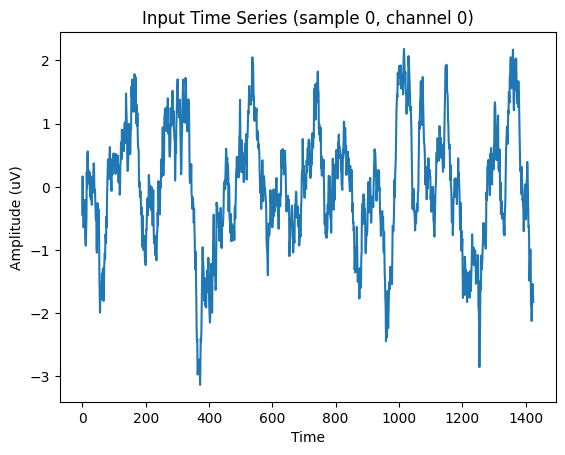

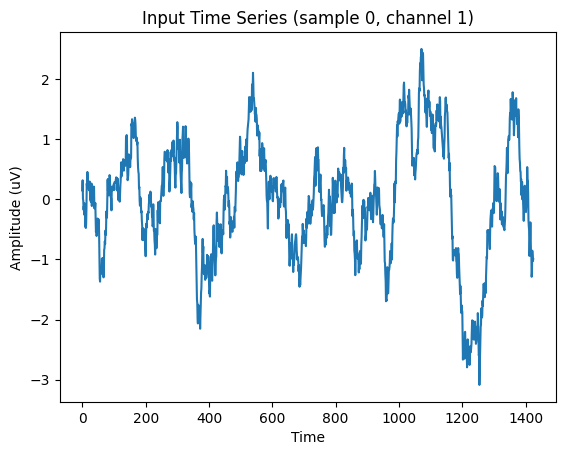

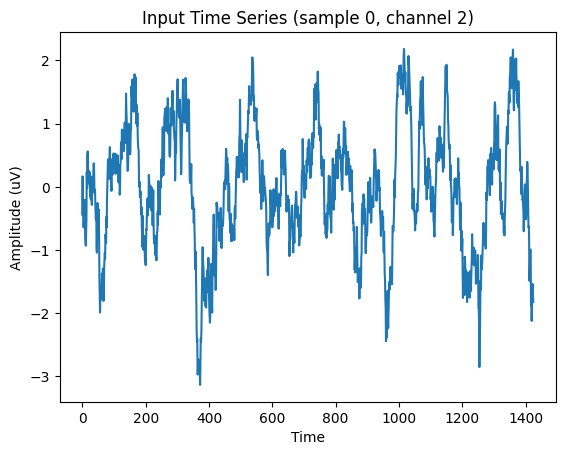

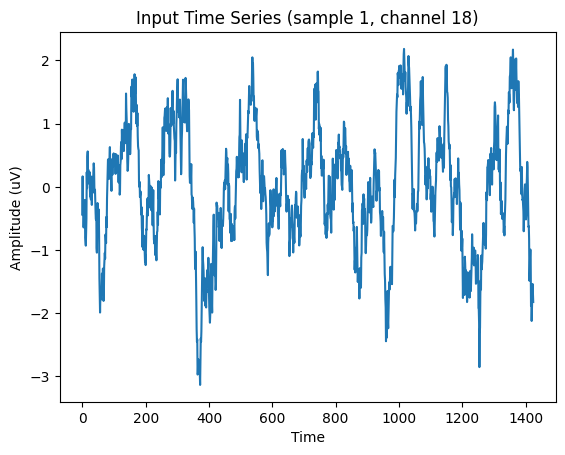

In [32]:
import matplotlib.pyplot as plt

# ─── 시계열 예시 (샘플 0, 채널 0) ───────────────────────────────
plt.figure()
plt.plot(X_small[0, 0].cpu().numpy())
plt.title("Input Time Series (sample 0, channel 0)")
plt.xlabel("Time")
plt.ylabel("Amplitude (uV)")
plt.show()

plt.figure()
plt.plot(X_small[0, 1].cpu().numpy())
plt.title("Input Time Series (sample 0, channel 1)")
plt.xlabel("Time")
plt.ylabel("Amplitude (uV)")
plt.show()

plt.figure()
plt.plot(X_small[0, 0].cpu().numpy())
plt.title("Input Time Series (sample 0, channel 2)")
plt.xlabel("Time")
plt.ylabel("Amplitude (uV)")
plt.show()

plt.figure()
plt.plot(X_small[0, 0].cpu().numpy())
plt.title("Input Time Series (sample 1, channel 18)")
plt.xlabel("Time")
plt.ylabel("Amplitude (uV)")
plt.show()


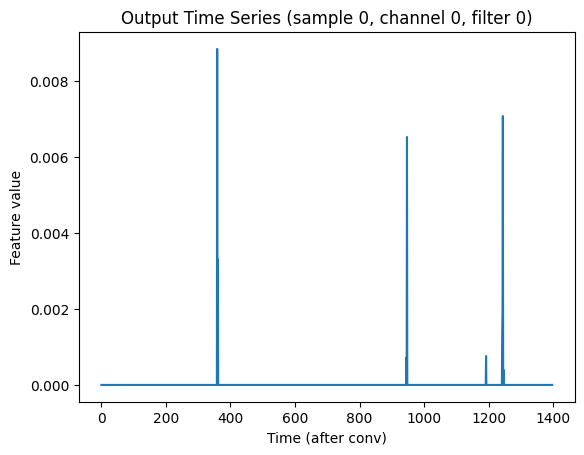

In [48]:
# 필터 0만 골라서
plt.figure()
plt.plot(z3[0, 0, 118].detach().cpu().numpy())
plt.title("Output Time Series (sample 0, channel 0, filter 0)")
plt.xlabel("Time (after conv)")
plt.ylabel("Feature value")
plt.show()

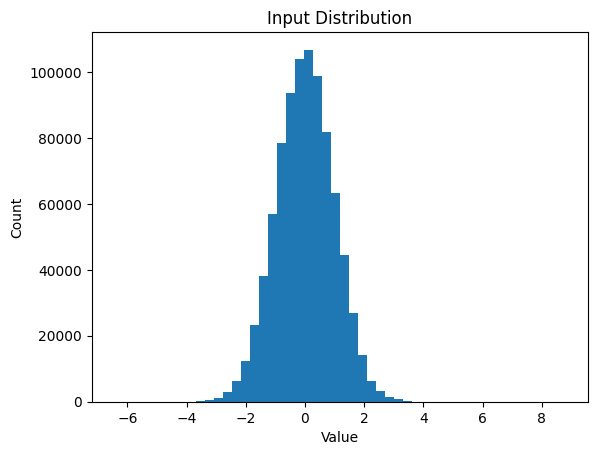

In [49]:
# ─── 분포 비교 (히스토그램) ──────────────────────────────────────
plt.figure()
plt.hist(X_small.cpu().numpy().flatten(), bins=50)
plt.title("Input Distribution")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

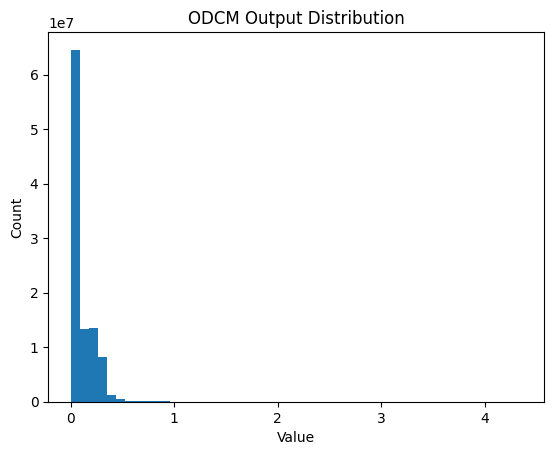

In [50]:
plt.figure()
plt.hist(z3.detach().cpu().numpy().flatten(), bins=50)
plt.title("ODCM Output Distribution")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

#### Regional Transformer output

In [52]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(embed_dim=dim, num_heads=heads,batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        # Feedforward MLP (dim->4*dim->dim)
        self.mlp   = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # 1) Self-Attention: Q=K=V=LN(x), attn_output: [B, Seq, D]
        y, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        # 2) Residual connection
        x = x + y
        # 3) Position-wise MLP + Residual
        x = x + self.mlp(self.norm2(x))
        return x


# === Regional Transformer Module ===
class RTM(nn.Module):
    def __init__(self,
                 num_regions:int,   # = S (# of Channels)
                 num_filters:int,   # = C (ODCM num_filters)
                 seq_len:int,       # = L_e (ODCM output time length)
                 embed_dim:int,     # Embedding Dimension D (D==C)
                 num_heads:int,
                 num_blocks:int):
        super().__init__()
        S, C, L, D = num_regions, num_filters, seq_len, embed_dim
        self.S, self.C, self.L = S, C, L

        # 1) linear patch embedding: R^{L_e} → R^{D}
        self.token_embed = nn.Linear(L, D)

        # 2) Classification Token
        self.cls_token   = nn.Parameter(torch.randn(1, 1, D))

        # 3) Positional Embedding (Combined Sequence length = 1 + S*C)
        self.pos_embed   = nn.Parameter(torch.randn(1, 1 + S*C, D))

        # 4) Transformer Blocks
        self.blocks = nn.Sequential(*[TransformerBlock(D, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        """
        x: [B, S, C, L]  
        returns: [B, S, C, D]
        """
        B, S, C, L = x.shape
        assert S==self.S and C==self.C and L==self.L

        # 1) Convert into token: [B, S, C, L] → [B, S*C, L]
        tokens = x.reshape(B, S*C, L)

        # 2) Linear Projection Embedding: [B, S*C, L] → [B, S*C, D]
        tokens = self.token_embed(tokens)

        # 3) Add classification token: → [B, 1+S*C, D]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        seq = torch.cat((cls_tokens, tokens), dim=1)

        # 4) Add positional embedding
        seq = seq + self.pos_embed

        # 5) Transformer Blocks
        seq = self.blocks(seq)  # [B, 1+S*C, D]

        # 6) Remove classification token → [B, S*C, D]
        seq = seq[:, 1:, :]

        # 7) return back to 4D → [B, S, C, D]
        out = seq.reshape(B, S, C, -1)
        return out

In [53]:
B,S,C,L_e = z3.shape
rtm = RTM(num_regions=S,
          num_filters=C,
          seq_len=L_e,
          embed_dim=C,    # 보통 D = num_filters
          num_heads=3,
          num_blocks=3)
z4 = rtm(z3)  # expected shape [B, S, C, D]
print("After RTM → z4.shape =", z4.shape)

After RTM → z4.shape = torch.Size([32, 19, 120, 120])


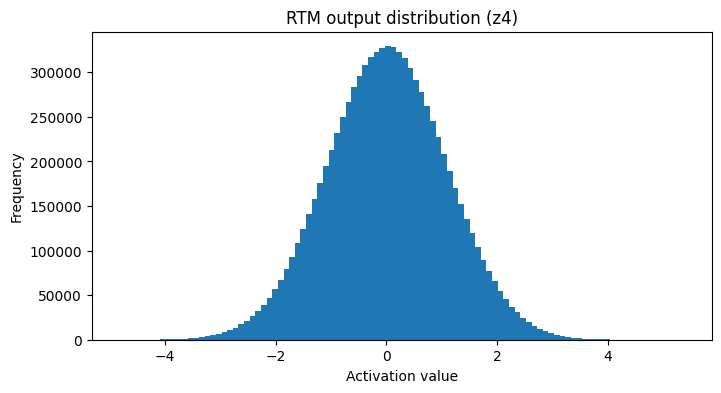

In [55]:
vals = z4.detach().cpu().reshape(-1).numpy()
# 또는
# vals = z4.detach().cpu().flatten().numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.hist(vals, bins=100)
plt.title("RTM output distribution (z4)")
plt.xlabel("Activation value")
plt.ylabel("Frequency")
plt.show()

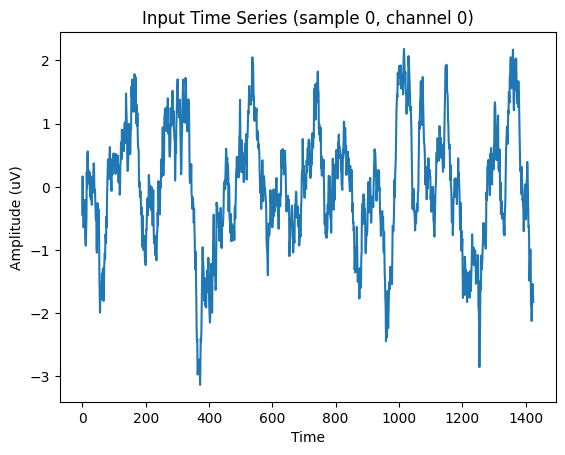

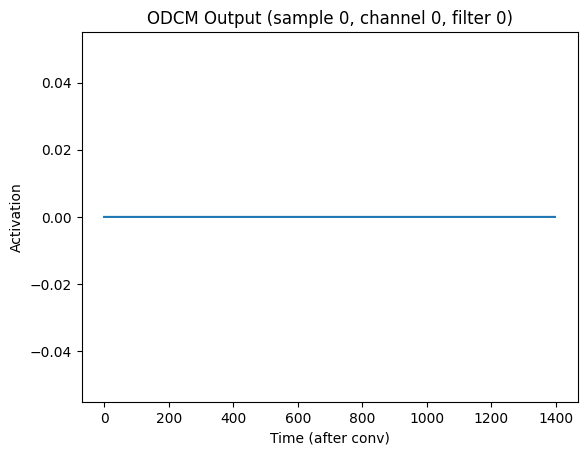

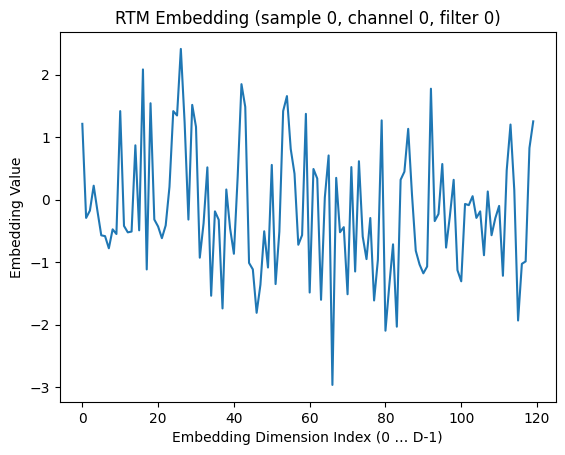

In [56]:
import matplotlib.pyplot as plt

# ─── 1) 원본 시계열 ──────────────────────────────────────────
plt.figure()
plt.plot(X_small[0, 0].cpu().numpy())
plt.title("Input Time Series (sample 0, channel 0)")
plt.xlabel("Time")
plt.ylabel("Amplitude (uV)")
plt.show()


# ─── 2) ODCM 출력 시계열 (첫 번째 필터) ───────────────────────
# z3.shape == [B, S, C, L_e]
# 여기서 sample=0, channel=0, filter=0
ts_z3 = z3[0, 0, 0, :].detach().cpu().numpy()

plt.figure()
plt.plot(ts_z3)
plt.title("ODCM Output (sample 0, channel 0, filter 0)")
plt.xlabel("Time (after conv)")
plt.ylabel("Activation")
plt.show()


# ─── 3) RTM(z4) 임베딩 벡터 (길이 D) ────────────────────────
# z4.shape == [B, S, C, D]
# sample=0, channel=0, filter=0 의 D차원 임베딩
embed_z4 = z4[0, 0, 0, :].detach().cpu().numpy()

plt.figure()
plt.plot(embed_z4)
plt.title("RTM Embedding (sample 0, channel 0, filter 0)")
plt.xlabel("Embedding Dimension Index (0 … D-1)")
plt.ylabel("Embedding Value")
plt.show()


In [18]:
# models.py
import torch
import torch.nn as nn


# === Depthwise Temporal Convolution ===
class ODCM(nn.Module):
    def __init__(self, in_channels, kernel_size, num_filters):
        super().__init__()
        S = in_channels
        C = num_filters # 120
        self.conv1 = nn.Conv1d(in_channels=S, out_channels=S, kernel_size=kernel_size, padding=0, groups=S) # kernel_size = 10
        self.conv2 = nn.Conv1d(in_channels=S, out_channels=S, kernel_size=kernel_size, padding=0, groups=S)
        self.conv3 = nn.Conv1d(in_channels=S, out_channels=S*C, kernel_size=kernel_size, padding=0, groups=S)
        self.relu = nn.ReLU()

    def forward(self, x):  # x = [B = Batch, S = Channels, L = Time] , C = Filters
        B,S,L = x.shape
        z1 = self.relu(self.conv1(x)) # z1 = [B, S*C, L1]
        z2 = self.relu(self.conv2(z1)) # z2 = [B, S*C*C, L2]
        z3buf = self.relu(self.conv3(z2)) # z3 [B, S*C*C*C, L3]
        
        # 4D reshape
        _,SC,L3 = z3buf.shape
        C = SC//S
        z3 = z3buf.view(B,S,C,L3)

        return z3 # [B, S, C, L3]

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(embed_dim=dim, num_heads=heads,batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        # Feedforward MLP (dim->4*dim->dim)
        self.mlp   = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # 1) Self-Attention: Q=K=V=LN(x), attn_output: [B, Seq, D]
        y, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        # 2) Residual connection
        x = x + y
        # 3) Position-wise MLP + Residual
        x = x + self.mlp(self.norm2(x))
        return x

"""
- Input z3: [B, S, C, L_e]
- 공간 축(S)을 따라 S개의 sub-matrix [C, L_e] 생성
- 각 sub-matrix의 C개 row를 토큰(token)으로 취급 → 총 S*C tokens
- 각 토큰은 R^{L_e} → R^{D} 로 선형 투영 → Transformer에 입력
"""

# === Regional Transformer Module ===
class RTM(nn.Module):
    def __init__(self,
                 num_regions:int,   # = S (# of Channels)
                 num_filters:int,   # = C (ODCM num_filters)
                 seq_len:int,       # = L_e (ODCM output time length)
                 embed_dim:int,     # Embedding Dimension D (D==C)
                 num_heads:int,
                 num_blocks:int):
        super().__init__()
        S, C, L, D = num_regions, num_filters, seq_len, embed_dim
        self.S, self.C, self.L = S, C, L

        # 1) linear patch embedding: R^{L_e} → R^{D}
        self.token_embed = nn.Linear(L, D)

        # 2) Classification Token
        self.cls_token   = nn.Parameter(torch.randn(1, 1, D))

        # 3) Positional Embedding (Combined Sequence length = 1 + S*C)
        self.pos_embed   = nn.Parameter(torch.randn(1, 1 + S*C, D))

        # 4) Transformer Blocks
        self.blocks = nn.Sequential(*[TransformerBlock(D, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        """
        x: [B, S, C, L]  
        returns: [B, S, C, D]
        """
        B, S, C, L = x.shape
        assert S==self.S and C==self.C and L==self.L

        # 1) Convert into token: [B, S, C, L] → [B, S*C, L]
        tokens = x.reshape(B, S*C, L)

        # 2) Linear Projection Embedding: [B, S*C, L] → [B, S*C, D]
        tokens = self.token_embed(tokens)

        # 3) Add classification token: → [B, 1+S*C, D]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        seq = torch.cat((cls_tokens, tokens), dim=1)

        # 4) Add positional embedding
        seq = seq + self.pos_embed

        # 5) Transformer Blocks
        seq = self.blocks(seq)  # [B, 1+S*C, D]

        # 6) Remove classification token → [B, S*C, D]
        seq = seq[:, 1:, :]

        # 7) return back to 4D → [B, S, C, D]
        out = seq.reshape(B, S, C, -1)
        return out


"""
입력 z4 ∈ R^{S×C×D} 에서
- C feature map별 submatrix X_syn_i ∈ R^{S×D}
- 각 row(D) → token (총 C*S tokens)
- Linear: D→D, pos_emb 추가, TransformerBlock 적용 :contentReference[oaicite:4]{index=4}&#8203;:contentReference[oaicite:5]{index=5}
출력 z5 ∈ R^{C×S×D}
"""
# === Synchronous Transformer Module ===
class STM(nn.Module):
    def __init__(self,
                 num_regions: int,   # S (# of channels)
                 num_filters: int,   # C (# of depthwise Filter)
                 embed_dim: int,     # D (Embedding Dimension, same as num_filters)
                 num_heads: int,
                 num_blocks: int):
        super().__init__()
        S, C, D = num_regions, num_filters, embed_dim
        self.S, self.C, self.D = S, C, D

        # For each token, linear patch embedding D->D mapping
        self.token_embed = nn.Linear(D, D)
        self.cls_token   = nn.Parameter(torch.randn(1, 1, D))
        self.pos_embed   = nn.Parameter(torch.randn(1, 1 + S*C, D))
        self.blocks = nn.Sequential(*[TransformerBlock(dim=D, heads=num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        """
        x: [B, S, C, D]
        returns: [B, S, C, D]
        """
        B, S, C, D = x.shape
        assert (S, C, D) == (self.S, self.C, self.D)

        # 1) [B, S, C, D] → [B, C, S, D]
        x_permuted = x.permute(0, 2, 1, 3)

        # 2) [B, C, S, D] → [B, C*S, D]  (flatten each sub-matrix's row into sequence)
        tokens = x_permuted.reshape(B, C * S, D)

        # 3) Linear Embedding (D→D)
        tokens = self.token_embed(tokens)  # [B, S*C, D]

        # 4) Add classification token
        cls_tokens = self.cls_token.expand(B, -1, -1) # [B, 1, D]
        seq = torch.cat((cls_tokens, tokens), dim=1) # [B, 1+S*C, D]

        # 5) Add Positional Embedding
        seq = seq + self.pos_embed # [B, 1+S*C, D]

        # 6) TransformerBlock × K
        seq = self.blocks(seq) # [B, 1+S*C, D]

        # 7) Remove Classification token
        seq = seq[:, 1:, :] # [B, S*C, D]

        # 8) Return to original 4D tensor: [B, C, S, D] → [B, S, C, D]
        out = seq.reshape(B, C, S, D).permute(0, 2, 1, 3)
        return out

# === Temporal Transformer Module ===
class TTM(nn.Module):
    def __init__(self,
                 num_segments: int,   # M, temporal segments
                 num_regions: int,   # S, # of channels
                 num_filters: int,   # C, # of filters
                 embed_dim: int,   # D, Embedding Dimension (After RTM, STM)
                 num_heads: int,
                 num_blocks: int,
                 dropout: float = 0.1):
        super().__init__()
        self.M = num_segments
        self.S = num_regions
        self.C = num_filters
        self.D = embed_dim

        # 1) Token Embedding: R^{S*C} → R^{D}
        self.token_embed = nn.Linear(self.S * self.C, self.D)

        # 2) classification token
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.D))

        # 3) positional embedding: total tokens = 1 + M
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.M, self.D))

        # 4) Transformer blocks
        self.blocks = nn.Sequential(*[TransformerBlock(dim=self.D, heads=num_heads, dropout=dropout) for _ in range(num_blocks)])
        # 5) LayerNorm
        self.ln = nn.LayerNorm(self.D)

    def forward(self, x):
        """
        x: [B, S, C, D]
        returns: [B, M, D]
        """
        B, S, C, D = x.shape
        assert (S, C, D) == (self.S, self.C, self.D), \
            f"Expected shape (S,C,D)=({self.S},{self.C},{self.D}), got {(S,C,D)}"

        # 1) Temporal (D) → M segments: Average into M submatrixes
        seg_len = D // self.M
        segments = []
        for i in range(self.M):
            seg = x[:, :, :, i*seg_len : (i+1)*seg_len]  # [B, S, C, seg_len]
            seg_mean = seg.mean(dim=-1)                  # [B, S, C]
            segments.append(seg_mean.unsqueeze(1))       # [B, 1, S, C]
        # Concatatenate M submatrixes -> [B, M, S, C]
        temp = torch.cat(segments, dim=1)

        # 2) Token Sequence: [B, M, S, C] → [B, M, S*C]
        tokens = temp.reshape(B, self.M, self.S * self.C)

        # 3) Linear projection: [B, M, S*C] → [B, M, D]
        tokens = self.token_embed(tokens)

        # 4) Classification Token: → [B, 1+M, D]
        cls_tokens = self.cls_token.expand(B, -1, -1)   # [B,1,D]
        seq = torch.cat((cls_tokens, tokens), dim=1)    # [B,1+M,D]

        # 5) Add positional embedding
        seq = seq + self.pos_embed                      # [B,1+M,D]

        # 6) Transformer blocks
        seq = self.blocks(seq)                          # [B,1+M,D]

        # 7) remove CLS token → [B, M, D]
        seq = seq[:, 1:, :]

        out = seq                                       # [B, M, D]
        return out



In [ ]:
odcm = ODCM(in_channels=19, kernel_size=10, num_filters=120)
z_3 = odcm(X_small)
B,S,C,L_e = z_3.shape
print(z_3.shape)

rtm = RTM(num_regions=S,
          num_filters=C,
          seq_len=L_e,
          embed_dim=C,    # 보통 D = num_filters
          num_heads=3,
          num_blocks=3)
z_4 = rtm(z_3)
B,S,C,D = z_4.shape
print(z_4.shape)

stm = STM(
    num_regions=S,
    num_filters=C,
    embed_dim=C,   # D = num_filters
    num_heads=3,
    num_blocks=3
)
z_5 = stm(z_4)
B,S,C,D = z_5.shape
print(z_5.shape)

ttm = TTM(
    num_segments=5,
    num_regions=S,
    num_filters=C,
    embed_dim=D,
    num_heads=3,
    num_blocks=3
)

z_6 = ttm(z_5)
B,M,D = z_6.shape
print(z_6.shape)


torch.Size([32, 19, 120, 1398])
torch.Size([32, 19, 120, 120])
torch.Size([32, 19, 120, 120])
torch.Size([32, 5, 120])


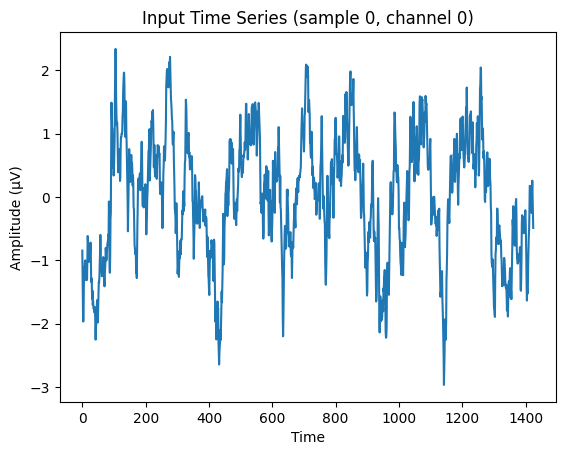

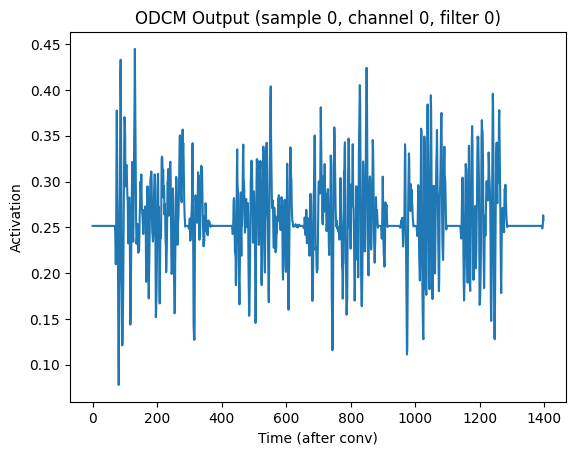

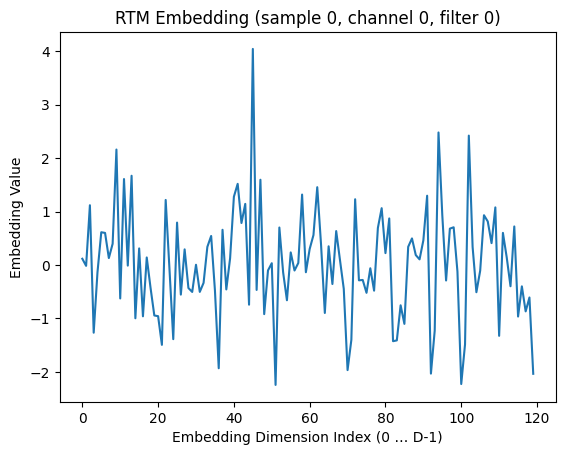

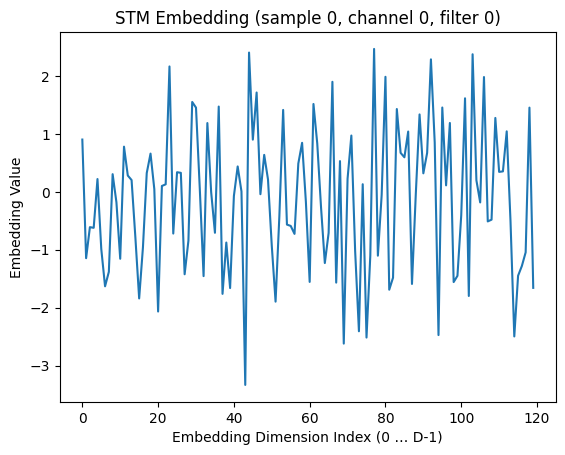

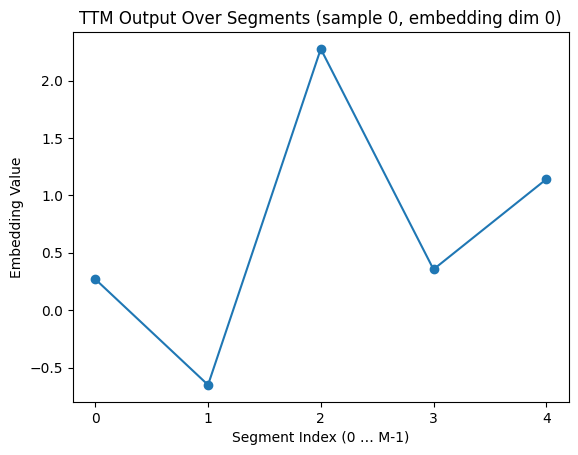

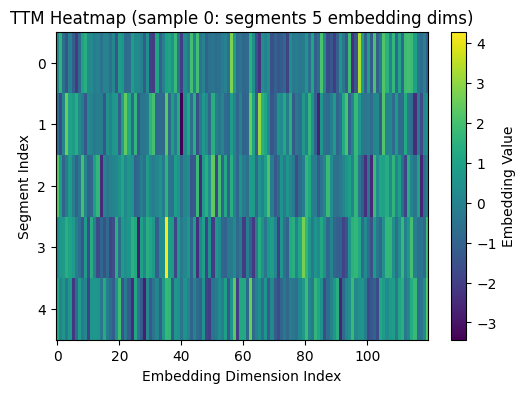

In [21]:
import matplotlib.pyplot as plt

# ─── 1) 원본 시계열 ──────────────────────────────────────────
plt.figure()
plt.plot(X_small[0, 0].cpu().numpy())
plt.title("Input Time Series (sample 0, channel 0)")
plt.xlabel("Time")
plt.ylabel("Amplitude (μV)")
plt.show()


# ─── 2) ODCM 출력 시계열 (첫 번째 필터) ───────────────────────
# z3.shape == [B, S, C, L_e]
# 여기서 sample=0, channel=0, filter=0
ts_z3 = z_3[0, 0, 0, :].detach().cpu().numpy()

plt.figure()
plt.plot(ts_z3)
plt.title("ODCM Output (sample 0, channel 0, filter 0)")
plt.xlabel("Time (after conv)")
plt.ylabel("Activation")
plt.show()


# ─── 3) RTM(z4) 임베딩 벡터 (길이 D) ────────────────────────
# z4.shape == [B, S, C, D]
# sample=0, channel=0, filter=0 의 D차원 임베딩
embed_z4 = z_4[0, 0, 0, :].detach().cpu().numpy()

plt.figure()
plt.plot(embed_z4)
plt.title("RTM Embedding (sample 0, channel 0, filter 0)")
plt.xlabel("Embedding Dimension Index (0 … D-1)")
plt.ylabel("Embedding Value")
plt.show()


# ─── 4) STM(z5) 임베딩 벡터 (길이 D) ────────────────────────
# z5.shape == [B, S, C, D]
# 여기도 sample=0, channel=0, filter=0 의 D차원 임베딩
embed_z5 = z_5[0, 0, 0, :].detach().cpu().numpy()

plt.figure()
plt.plot(embed_z5)
plt.title("STM Embedding (sample 0, channel 0, filter 0)")
plt.xlabel("Embedding Dimension Index (0 … D-1)")
plt.ylabel("Embedding Value")
plt.show()


# ─── 5) TTM(z6) 세그먼트별 출력 (M segments, 길이 D) ──────────
# z6.shape == [B, M, D]
# 예시로, embedding dimension 0번 채널의 값을 M개 세그먼트에 걸쳐 그려보기
seg_idx = list(range(z_6.shape[1]))
ttm_series = z_6[0, :, 0].detach().cpu().numpy()  # sample=0, embedding dim=0

plt.figure()
plt.plot(seg_idx, ttm_series, marker='o')
plt.title("TTM Output Over Segments (sample 0, embedding dim 0)")
plt.xlabel("Segment Index (0 … M-1)")
plt.ylabel("Embedding Value")
plt.xticks(seg_idx)
plt.show()


# ─── 보너스: TTM 전체 heatmap ─────────────────────────────────
plt.figure(figsize=(6,4))
plt.imshow(z_6[0].detach().cpu().numpy(), aspect='auto')
plt.title("TTM Heatmap (sample 0: segments 5 embedding dims)")
plt.xlabel("Embedding Dimension Index")
plt.ylabel("Segment Index")
plt.colorbar(label="Embedding Value")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_encodings(X_small, y_small, odcm, rtm, stm, ttm, sample_idx=0):
    """
    Visualization for a single sample in the batch:
      1) ODCM (1DCNN) output z3
      2) RTM output z4
      3) STM output z5
      4) TTM output z6
    plotted in sequence as heatmaps / line‐plots.
    """
    with torch.no_grad():
        z3 = odcm(X_small)    # [B, S, C, L_e]
        z4 = rtm(z3)          # [B, S, C, D]
        z5 = stm(z4)          # [B, S, C, D]
        z6 = ttm(z5)          # [B, M, D]

    label = y_small[sample_idx].item()

    # 1) ODCM z3: average over filter‐dim → [S, L_e]
    z3_avg = z3[sample_idx].mean(dim=1).detach().cpu().numpy()

    # 2) RTM & STM: average over filter‐dim → [S, D]
    z4_avg = z4[sample_idx].mean(dim=1).detach().cpu().numpy()
    z5_avg = z5[sample_idx].mean(dim=1).detach().cpu().numpy()

    # 3) TTM: token‐sequence map → [M, D]
    z6_map = z6[sample_idx].detach().cpu().numpy()

    # 4) Plot
    fig, axes = plt.subplots(4, 1, figsize=(12, 16))

    im0 = axes[0].imshow(z3_avg, aspect='auto', origin='lower')
    axes[0].set_title(f'ODCM Output (mean over filters)\nSample {sample_idx}, Label {label}')
    axes[0].set_ylabel('Channels (S)')
    axes[0].set_xlabel('Time index (L_e)')
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(z4_avg, aspect='auto', origin='lower')
    axes[1].set_title('After RTM (Regional Transformer)\nMean over filters')
    axes[1].set_ylabel('Channels (S)')
    axes[1].set_xlabel('Embedding dimension (D)')
    fig.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(z5_avg, aspect='auto', origin='lower')
    axes[2].set_title('After STM (Synchronous Transformer)\nMean over filters')
    axes[2].set_ylabel('Channels (S)')
    axes[2].set_xlabel('Embedding dimension (D)')
    fig.colorbar(im2, ax=axes[2])

    im3 = axes[3].imshow(z6_map, aspect='auto', origin='lower')
    axes[3].set_title('After TTM (Temporal Transformer)\nToken heatmap')
    axes[3].set_ylabel('Time segments (M)')
    axes[3].set_xlabel('Embedding dimension (D)')
    fig.colorbar(im3, ax=axes[3])

    plt.tight_layout()
    plt.show()


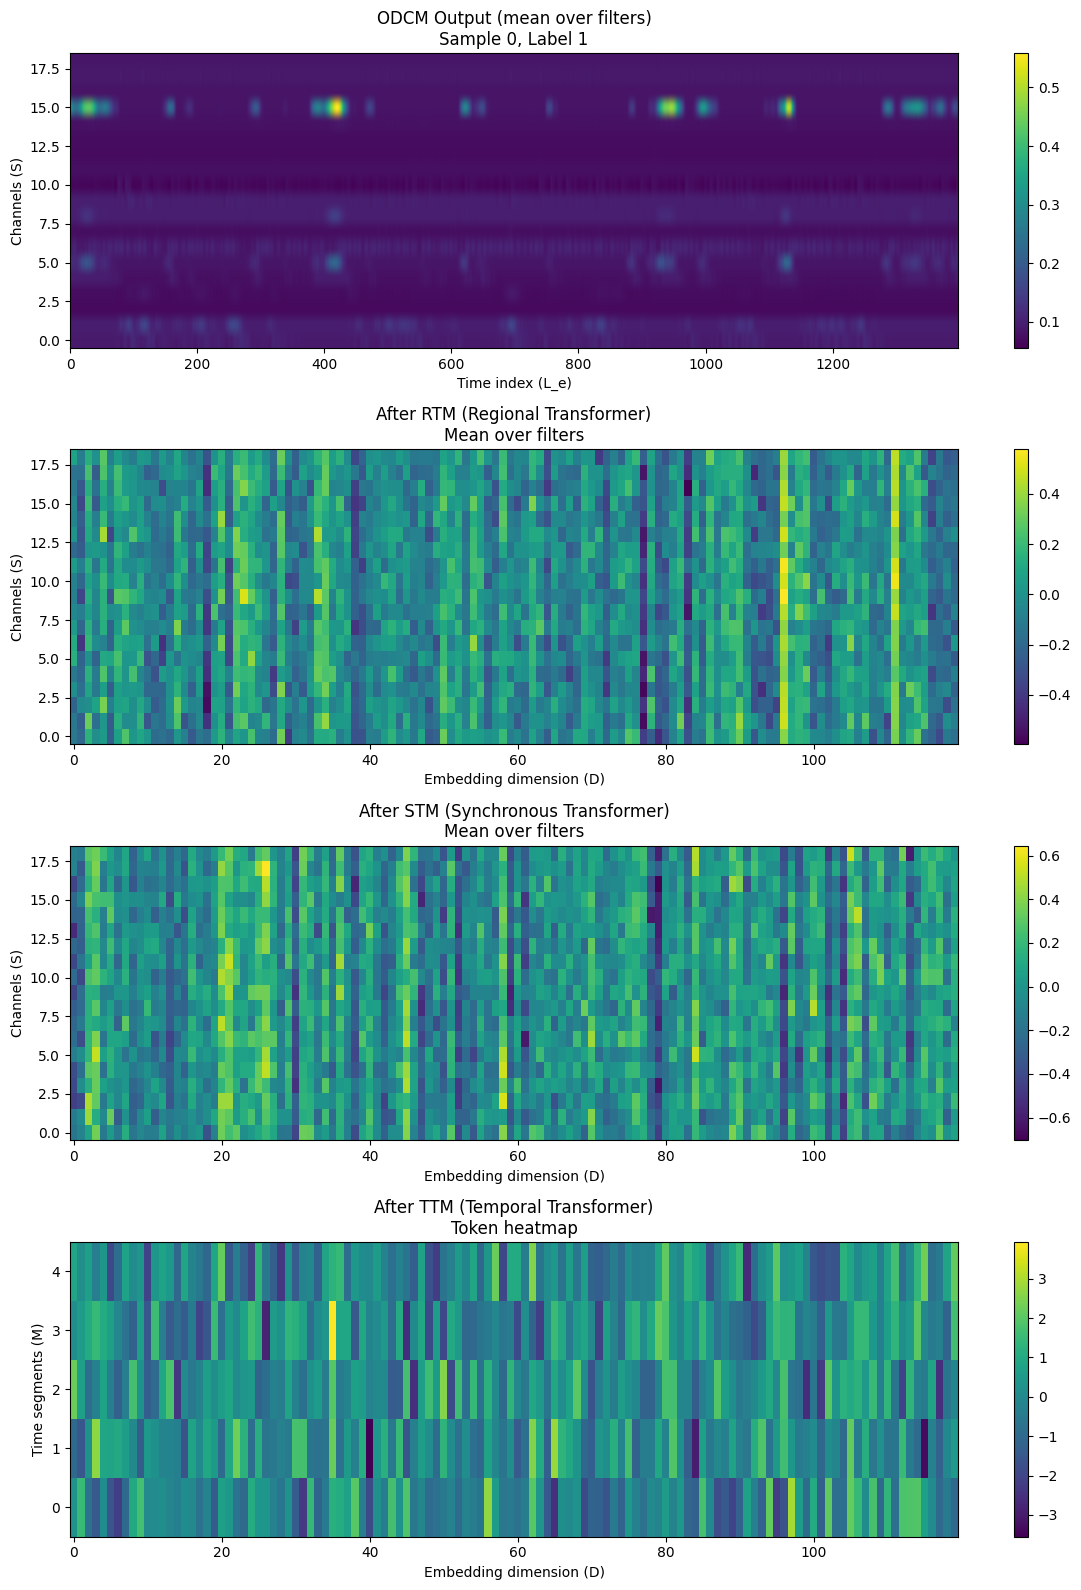

In [23]:
# 4) 함수 호출해서 한 번 그려보기
visualize_encodings(X_small, y_small, odcm, rtm, stm, ttm, sample_idx=0)

In [ ]:
# === Depthwise Temporal Convolution ===
class ODCM(nn.Module):
    def __init__(self, in_channels, kernel_size, num_filters):
        super().__init__()
        S = in_channels
        C = num_filters # 120
        self.conv1 = nn.Conv1d(in_channels=S, out_channels=S*C, kernel_size=kernel_size, padding=0, groups=S) # kernel_size = 10
        self.conv2 = nn.Conv1d(in_channels=S*C, out_channels=S*C, kernel_size=kernel_size, padding=0, groups=S*C)
        self.conv3 = nn.Conv1d(in_channels=S*C, out_channels=S*C, kernel_size=kernel_size, padding=0, groups=S*C)
        self.relu = nn.ReLU()

    def forward(self, x):  # x = [B = Batch, S = Channels, L = Time] , C = Filters
        B,S,L = x.shape
        z1 = self.relu(self.conv1(x)) # z1 = [B, S*C, L1]
        z2 = self.relu(self.conv2(z1)) # z2 = [B, S*C*C, L2]
        z3buf = self.relu(self.conv3(z2)) # z3 [B, S*C*C*C, L3]
        
        # 4D reshape
        _,SC,L3 = z3buf.shape
        C = SC//S
        z3 = z3buf.view(B,S,C,L3)

        return z3 # [B, S, C, L3]

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(embed_dim=dim, num_heads=heads,batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        # Feedforward MLP (dim->4*dim->dim)
        self.mlp   = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # 1) Self-Attention: Q=K=V=LN(x), attn_output: [B, Seq, D]
        y, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        # 2) Residual connection
        x = x + y
        # 3) Position-wise MLP + Residual
        x = x + self.mlp(self.norm2(x))
        return x

"""
- Input z3: [B, S, C, L_e]
- 공간 축(S)을 따라 S개의 sub-matrix [C, L_e] 생성
- 각 sub-matrix의 C개 row를 토큰(token)으로 취급 → 총 S*C tokens
- 각 토큰은 R^{L_e} → R^{D} 로 선형 투영 → Transformer에 입력
"""

# === Regional Transformer Module ===
class RTM(nn.Module):
    def __init__(self,
                 num_regions:int,   # = S (# of Channels)
                 num_filters:int,   # = C (ODCM num_filters)
                 seq_len:int,       # = L_e (ODCM output time length)
                 embed_dim:int,     # Embedding Dimension D (D==C)
                 num_heads:int,
                 num_blocks:int):
        super().__init__()
        S, C, L, D = num_regions, num_filters, seq_len, embed_dim
        self.S, self.C, self.L = S, C, L

        # 1) linear patch embedding: R^{L_e} → R^{D}
        self.token_embed = nn.Linear(L, D)

        # 2) Classification Token
        self.cls_token   = nn.Parameter(torch.randn(1, 1, D))

        # 3) Positional Embedding (Combined Sequence length = 1 + S*C)
        self.pos_embed   = nn.Parameter(torch.randn(1, 1 + S*C, D))

        # 4) Transformer Blocks
        self.blocks = nn.Sequential(*[TransformerBlock(D, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        """
        x: [B, S, C, L]  
        returns: [B, S, C, D]
        """
        B, S, C, L = x.shape
        assert S==self.S and C==self.C and L==self.L

        # 1) Convert into token: [B, S, C, L] → [B, S*C, L]
        tokens = x.reshape(B, S*C, L)

        # 2) Linear Projection Embedding: [B, S*C, L] → [B, S*C, D]
        tokens = self.token_embed(tokens)

        # 3) Add classification token: → [B, 1+S*C, D]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        seq = torch.cat((cls_tokens, tokens), dim=1)

        # 4) Add positional embedding
        seq = seq + self.pos_embed

        # 5) Transformer Blocks
        seq = self.blocks(seq)  # [B, 1+S*C, D]

        # 6) Remove classification token → [B, S*C, D]
        seq = seq[:, 1:, :]

        # 7) return back to 4D → [B, S, C, D]
        out = seq.reshape(B, S, C, -1)
        return out


"""
입력 z4 ∈ R^{S×C×D} 에서
- C feature map별 submatrix X_syn_i ∈ R^{S×D}
- 각 row(D) → token (총 C*S tokens)
- Linear: D→D, pos_emb 추가, TransformerBlock 적용 :contentReference[oaicite:4]{index=4}&#8203;:contentReference[oaicite:5]{index=5}
출력 z5 ∈ R^{C×S×D}
"""
# === Synchronous Transformer Module ===
class STM(nn.Module):
    def __init__(self,
                 num_regions: int,   # S (# of channels)
                 num_filters: int,   # C (# of depthwise Filter)
                 embed_dim: int,     # D (Embedding Dimension, same as num_filters)
                 num_heads: int,
                 num_blocks: int):
        super().__init__()
        S, C, D = num_regions, num_filters, embed_dim
        self.S, self.C, self.D = S, C, D

        # For each token, linear patch embedding D->D mapping
        self.token_embed = nn.Linear(D, D)
        self.cls_token   = nn.Parameter(torch.randn(1, 1, D))
        self.pos_embed   = nn.Parameter(torch.randn(1, 1 + S*C, D))
        self.blocks = nn.Sequential(*[TransformerBlock(dim=D, heads=num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        """
        x: [B, S, C, D]
        returns: [B, S, C, D]
        """
        B, S, C, D = x.shape
        assert (S, C, D) == (self.S, self.C, self.D)

        # 1) [B, S, C, D] → [B, C, S, D]
        x_permuted = x.permute(0, 2, 1, 3)

        # 2) [B, C, S, D] → [B, C*S, D]  (flatten each sub-matrix's row into sequence)
        tokens = x_permuted.reshape(B, C * S, D)

        # 3) Linear Embedding (D→D)
        tokens = self.token_embed(tokens)  # [B, S*C, D]

        # 4) Add classification token
        cls_tokens = self.cls_token.expand(B, -1, -1) # [B, 1, D]
        seq = torch.cat((cls_tokens, tokens), dim=1) # [B, 1+S*C, D]

        # 5) Add Positional Embedding
        seq = seq + self.pos_embed # [B, 1+S*C, D]

        # 6) TransformerBlock × K
        seq = self.blocks(seq) # [B, 1+S*C, D]

        # 7) Remove Classification token
        seq = seq[:, 1:, :] # [B, S*C, D]

        # 8) Return to original 4D tensor: [B, C, S, D] → [B, S, C, D]
        out = seq.reshape(B, C, S, D).permute(0, 2, 1, 3)
        return out

# === Temporal Transformer Module ===
class TTM(nn.Module):
    def __init__(self,
                 num_segments: int,   # M, temporal segments
                 num_regions: int,   # S, # of channels
                 num_filters: int,   # C, # of filters
                 embed_dim: int,   # D, Embedding Dimension (After RTM, STM)
                 num_heads: int,
                 num_blocks: int,
                 dropout: float = 0.1):
        super().__init__()
        self.M = num_segments
        self.S = num_regions
        self.C = num_filters
        self.D = embed_dim

        # 1) Token Embedding: R^{S*C} → R^{D}
        self.token_embed = nn.Linear(self.S * self.C, self.D)

        # 2) classification token
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.D))

        # 3) positional embedding: total tokens = 1 + M
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.M, self.D))

        # 4) Transformer blocks
        self.blocks = nn.Sequential(*[TransformerBlock(dim=self.D, heads=num_heads, dropout=dropout) for _ in range(num_blocks)])
        # 5) LayerNorm
        self.ln = nn.LayerNorm(self.D)
        self.out_proj = nn.Linear(self.D, self.S * self.C)

    def forward(self, x):
        """
        x: [B, S, C, D]
        returns: [B, M, D]
        """
        B, S, C, D = x.shape
        assert (S, C, D) == (self.S, self.C, self.D), \
            f"Expected shape (S,C,D)=({self.S},{self.C},{self.D}), got {(S,C,D)}"

        # 1) Temporal (D) → M segments: Average into M submatrixes
        seg_len = D // self.M
        segments = []
        for i in range(self.M):
            seg = x[:, :, :, i*seg_len : (i+1)*seg_len]  # [B, S, C, seg_len]
            seg_mean = seg.mean(dim=-1)                  # [B, S, C]
            segments.append(seg_mean.unsqueeze(1))       # [B, 1, S, C]
        # Concatatenate M submatrixes -> [B, M, S, C]
        temp = torch.cat(segments, dim=1)

        # 2) Token Sequence: [B, M, S, C] → [B, M, S*C]
        tokens = temp.reshape(B, self.M, self.S * self.C)

        # 3) Linear projection: [B, M, S*C] → [B, M, D]
        tokens = self.token_embed(tokens)

        # 4) Classification Token: → [B, 1+M, D]
        cls_tokens = self.cls_token.expand(B, -1, -1)   # [B,1,D]
        seq = torch.cat((cls_tokens, tokens), dim=1)    # [B,1+M,D]

        # 5) Add positional embedding
        seq = seq + self.pos_embed                      # [B,1+M,D]

        # 6) Transformer blocks
        seq = self.blocks(seq)                          # [B,1+M,D]

        # 7) remove CLS token → [B, M, D]
        seq = seq[:, 1:, :]

        seq = self.ln(seq)
        out = self.out_proj(seq) # [B, M, S*C]
        
        return out


# === CNN Decoder ===
class CNNDecoder(nn.Module):
    def __init__(
        self,
        num_regions: int,    # S: number of channels
        num_filters: int,    # C: number of depthwise filters
        num_segments: int,   # M: number of temporal segments after TTM
        num_classes: int     # number of output classes
    ):
        super().__init__()
        self.num_regions = num_regions
        self.num_filters = num_filters
        self.num_segments = num_segments

        # 1) channel-fusion: C → 1 via 1×1 Conv2d
        #    input: [B, C, S, M] → [B, 1, S, M]
        self.conv1 = nn.Conv2d(in_channels=self.num_filters, out_channels=1, kernel_size=(1, 1), bias=True)

        # 2) spatial-fusion: S → N
        #    input: [B, 1, S, M] → [B, N, 1, M]
        N = 16
        self.conv2 = nn.Conv2d(in_channels=1,out_channels=N,kernel_size=(self.num_regions, 1),bias=True)

        # 3) temporal down-sample: M → M//2
        #    input: [B, N, 1, M] → [B, N2, 1, M//2]
        N2 = 32
        self.conv3 = nn.Conv2d(in_channels=N,out_channels=N2,kernel_size=(1, 2),stride=(1, 2),bias=True)

        # 4) final classifier
        #    flattened features: N2 * (M//2)
        self.fc   = nn.Linear(N2 * (self.num_segments // 2), num_classes)
        self.relu = nn.ReLU()

    def forward(self, O: torch.Tensor):
        """
        Args:
            O: Tensor of shape [B, M, S*C]
            M = num_segments, S = num_regions, C = num_filters
        Returns:
            logits: Tensor of shape [B, num_classes]
        """
        B, M, SC = O.shape
        assert (M, SC) == (self.num_segments, self.num_regions * self.num_filters), \
            f"Expected O.shape=(B, {self.num_segments}, {self.num_regions * self.num_filters}), got {O.shape}"

        # reshape back to 4D: [B, M, S, C] → permute to [B, C, S, M]
        x = O.view(B, M, self.num_regions, self.num_filters) \
             .permute(0, 3, 2, 1)  # → [B, C, S, M]

        # 1) channel-fusion
        x = self.relu(self.conv1(x))   # [B, 1, S, M]

        # 2) spatial-fusion
        x = self.relu(self.conv2(x))   # [B, N, 1, M]

        # 3) temporal down-sample
        x = self.relu(self.conv3(x))   # [B, N2, 1, M//2]

        # 4) flatten and classify
        x = x.view(B, -1)              # [B, N2 * (M//2)]
        logits = self.fc(x)            # [B, num_classes]

        return logits

In [30]:
odcm = ODCM(in_channels=19, kernel_size=10, num_filters=120)
z_3 = odcm(X_small)
B,S,C,L_e = z_3.shape
print(z_3.shape)

rtm = RTM(num_regions=S,
          num_filters=C,
          seq_len=L_e,
          embed_dim=C,    # 보통 D = num_filters
          num_heads=3,
          num_blocks=3)
z_4 = rtm(z_3)
B,S,C,D = z_4.shape
print(z_4.shape)

stm = STM(
    num_regions=S,
    num_filters=C,
    embed_dim=C,   # D = num_filters
    num_heads=3,
    num_blocks=3
)
z_5 = stm(z_4)
B,S,C,D = z_5.shape
print(z_5.shape)

ttm = TTM(
    num_segments=5,
    num_regions=S,
    num_filters=C,
    embed_dim=D,
    num_heads=3,
    num_blocks=3
)

z_6 = ttm(z_5)
B,M,D = z_6.shape
print(z_6.shape)

# === (5) CNNDecoder → z_7 ===
decoder = CNNDecoder(
    num_regions=S,
    num_filters=C,
    num_segments=M,
    num_classes=3   # 예를 들어 3개 클래스 분류
)
z_7 = decoder(z_6)
print(z_7.shape)  # [B, num_classes]


RuntimeError: Given groups=2280, weight of size [2280, 1, 10], expected input[32, 19, 1416] to have 2280 channels, but got 19 channels instead

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_encodings(X_small, y_small, odcm, rtm, stm, ttm, sample_idx=0):
    """
    Visualization for a single sample in the batch:
      1) ODCM (1DCNN) output z3
      2) RTM output z4
      3) STM output z5
      4) TTM output z6
    plotted in sequence as heatmaps / line‐plots.
    """
    with torch.no_grad():
        z3 = odcm(X_small)    # [B, S, C, L_e]
        z4 = rtm(z3)          # [B, S, C, D]
        z5 = stm(z4)          # [B, S, C, D]
        z6 = ttm(z5)          # [B, M, D]

    label = y_small[sample_idx].item()

    # 1) ODCM z3: average over filter‐dim → [S, L_e]
    z3_avg = z3[sample_idx].mean(dim=1).detach().cpu().numpy()

    # 2) RTM & STM: average over filter‐dim → [S, D]
    z4_avg = z4[sample_idx].mean(dim=1).detach().cpu().numpy()
    z5_avg = z5[sample_idx].mean(dim=1).detach().cpu().numpy()

    # 3) TTM: token‐sequence map → [M, D]
    z6_map = z6[sample_idx].detach().cpu().numpy()

    # 4) Plot
    fig, axes = plt.subplots(4, 1, figsize=(12, 16))

    im0 = axes[0].imshow(z3_avg, aspect='auto', origin='lower')
    axes[0].set_title(f'ODCM Output (mean over filters)\nSample {sample_idx}, Label {label}')
    axes[0].set_ylabel('Channels (S)')
    axes[0].set_xlabel('Time index (L_e)')
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(z4_avg, aspect='auto', origin='lower')
    axes[1].set_title('After RTM (Regional Transformer)\nMean over filters')
    axes[1].set_ylabel('Channels (S)')
    axes[1].set_xlabel('Embedding dimension (D)')
    fig.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(z5_avg, aspect='auto', origin='lower')
    axes[2].set_title('After STM (Synchronous Transformer)\nMean over filters')
    axes[2].set_ylabel('Channels (S)')
    axes[2].set_xlabel('Embedding dimension (D)')
    fig.colorbar(im2, ax=axes[2])

    im3 = axes[3].imshow(z6_map, aspect='auto', origin='lower')
    axes[3].set_title('After TTM (Temporal Transformer)\nToken heatmap')
    axes[3].set_ylabel('Time segments (M)')
    axes[3].set_xlabel('Embedding dimension (D)')
    fig.colorbar(im3, ax=axes[3])

    plt.tight_layout()
    plt.show()
